<a href="https://colab.research.google.com/github/AvivGelfand/Modern-Statistical-Strategies-Course/blob/main/Advanced_Statistical_Data_Analysis_Ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q1 Wald Test Vs Permutation Test


## a) Least Square Estimate $β_{ls}$


### Task Breakdown
1. **Generate Data:**
   - $ x_i \in \mathbb{R}^p $ is generated according to a uniform distribution $ U[0,1]^p $.
   - $ y_i = \langle x_i, \beta^* \rangle + \sigma \xi_i $, where $ \xi_i \sim N(0,1) $.
  - `beta_star` is a vector of length $ p $ with the first $ \tau $ elements set to 1 and the rest to 0.

2. **Hypothesis Testing:**
   - Null hypothesis $ H_0: \beta(i) = 0 $
   - Alternative hypothesis $ H_1: \beta(i) \neq 0 $

3. **Compute $ \beta_{ls} $:**
   - $ \beta_{ls} = (X^TX)^{-1}X^Ty $

4. **Variance Calculation:**
   - $ V(\beta_{ls}(i)) = \sigma^2 (\tilde{X}^T \tilde{X})^{-1} $


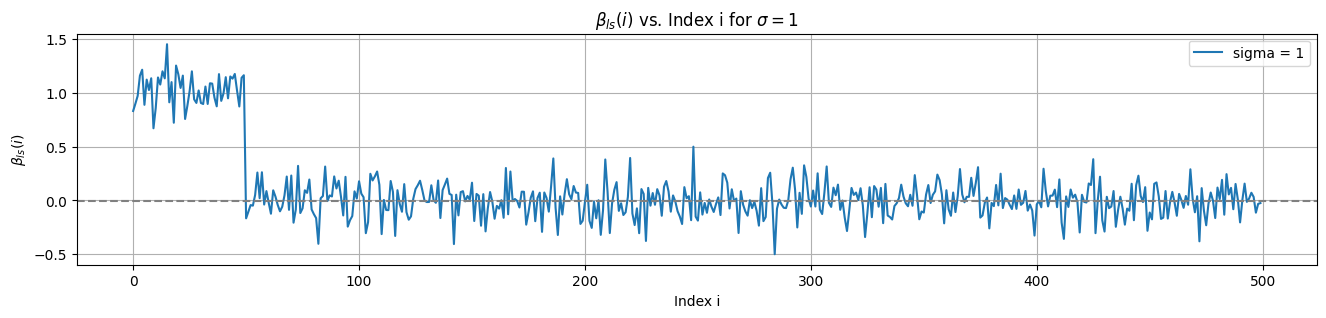

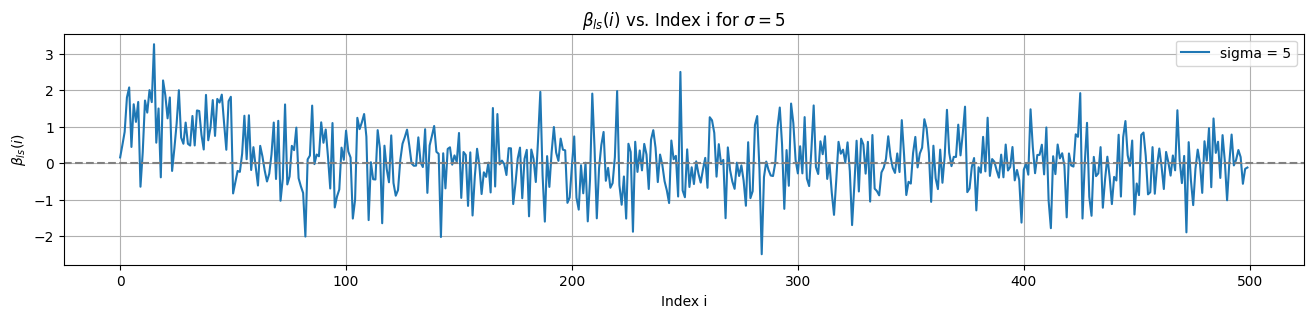

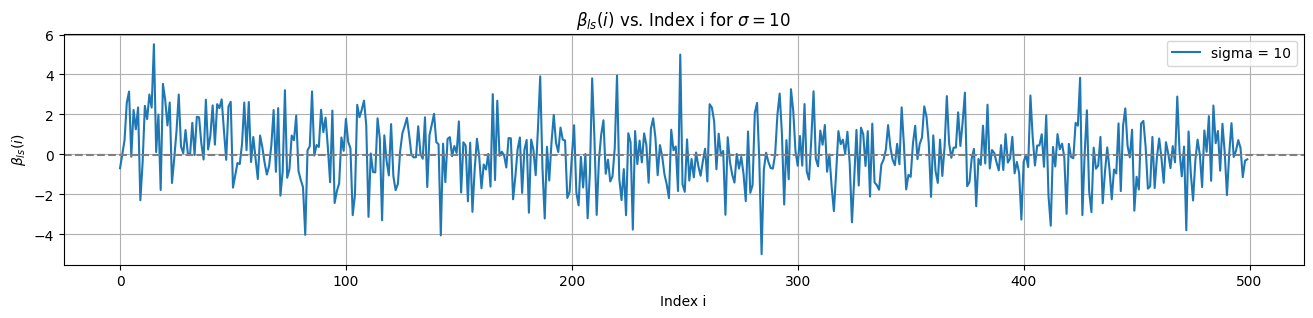

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
m = 1000  # number of samples
p = 500   # number of features
tau = 50  # number of non-zero coefficients
sigma_values = [1, 5, 10]  # different noise levels

# Generate beta*
beta_star = np.zeros(p)
beta_star[:tau] = 1

# Generate data
X = np.random.uniform(0, 1, (m, p))
noise = np.random.normal(0, 1, m)

# Function to compute beta_ls
def compute_beta_ls(X, y):
    return np.linalg.inv(X.T @ X) @ X.T @ y

# Plot beta_ls for different sigma values

for sigma in sigma_values:
    plt.figure(figsize=(16, 3))
    # gridlines
    plt.grid(True)
    y = X @ beta_star + sigma * noise
    beta_ls = compute_beta_ls(X, y)

    # Centering X
    X_centered = X - X.mean(axis=0)

    plt.plot(beta_ls, label=f'sigma = {sigma}')
    plt.axhline(-0.003, color='grey', linestyle='--')
    # plt.axhline(-1.003, color='grey', linestyle='--')

    plt.xlabel('Index i');
    plt.ylabel(r'$\beta_{ls}(i)$');
    plt.title(r'$\beta_{ls}(i)$ vs. Index i for $\sigma=$'+f'{sigma}');
    plt.legend();
    plt.show();
    print("")

## 1. (b) Comparing Wald Test with Permutation Test

### 1. `compute_beta_ls` Function
This function computes the least squares estimate $\beta_{ls}$. See section 1. (a)



- **Input:**
  - `X`: Design matrix of shape $(m, p)$
  - `y`: Response vector of shape $(m, )$
  
- **Calculation:**
  - $\beta_{ls} = (X^T X)^{-1} X^T y$
  - This is the closed-form solution for the ordinary least squares (OLS) problem, which minimizes the residual sum of squares between the observed responses in `y` and the responses predicted by the linear approximation.



### 2. `permutation_worker` Function
This worker function is used for parallel processing of permutations.


In [16]:
def permutation_worker(X, y, indices, output):
    y_permuted = y[indices]
    perm_beta_ls = compute_beta_ls(X, y_permuted)
    output.put(perm_beta_ls)


- **Input:**
  - `X`: Design matrix of shape $(m, p)$
  - `y`: Response vector of shape $(m, )$
  - `indices`: A permutation of indices used to shuffle `y`
  - `output`: A multiprocessing queue to store results
  
- **Calculation:**
  - `y_permuted`: Permuted version of `y` using `indices`
  - `perm_beta_ls`: Least squares estimate $\beta_{ls}$ for the permuted data
  - Puts the computed $\beta_{ls}$ into the `output` queue for later retrieval.



### 3. `permutation_test_optimized` Function
For optimal running time, this function performs the permutation test using parallel processing.


In [17]:
def permutation_test_optimized(X, y, n_permutations=500, n_jobs=4):
    n, p = X.shape
    beta_ls = compute_beta_ls(X, y)
    p_values = np.zeros(p)

    indices = [np.random.permutation(n) for _ in range(n_permutations)]

    with mp.Pool(n_jobs) as pool:
        manager = mp.Manager()
        output = manager.Queue()

        jobs = [pool.apply_async(permutation_worker, args=(X, y, indices[i], output)) for i in range(n_permutations)]

        for job in jobs:
            job.get()

        perm_stats = [output.get() for _ in range(n_permutations)]

    perm_stats = np.array(perm_stats)

    for j in range(p):
        perm_stats_j = perm_stats[:, j]
        p_values[j] = np.mean(np.abs(perm_stats_j) >= np.abs(beta_ls[j]))

    return p_values



- **Input:**
  - `X`: Design matrix of shape $(m, p)$
  - `y`: Response vector of shape $(m, )$
  - `n_permutations`: Number of permutations to perform (default is 500)
  - `n_jobs`: Number of parallel jobs (default is 4)
  
- **Calculation:**
  - Compute the least squares estimate $\beta_{ls}$ for the original data.
  - Generate `n_permutations` different permutations of the response vector `y`.
  - Create a multiprocessing pool and manager queue for parallel processing.
  - Assign permutation tasks to worker processes.
  - Collect results from the queue after all jobs are complete.
  - For each feature $j$, calculate the p-value as the proportion of permuted $\beta_{ls}$ values that are as extreme or more extreme than the observed $\beta_{ls}$ value.



### 4. `wald_test` Function
This function performs the Wald test to compute p-values.


In [18]:
def wald_test(X, y, sigma):
    beta_ls = compute_beta_ls(X, y)
    X_centered = X - X.mean(axis=0)
    inv_XtX = np.linalg.inv(X_centered.T @ X_centered)
    var_beta_ls = sigma**2 * np.diag(inv_XtX)
    wald_stats = beta_ls / np.sqrt(var_beta_ls)
    p_values = 2 * (1 - norm.cdf(np.abs(wald_stats)))
    return p_values


- **Input:**
  - `X`: Design matrix of shape $(m, p)$
  - `y`: Response vector of shape $(m, )$
  - `sigma`: Standard deviation of the noise
  
- **Calculation:**
  - Compute the least squares estimate $\beta_{ls}$ for the original data.
  - Center the design matrix $X$ by subtracting the mean of each column.
  - Calculate the inverse of $X_{centered}^T X_{centered}$.
  - Compute the variance of the least squares estimates $\sigma^2 \text{diag}((X_{centered}^T X_{centered})^{-1})$.
  - Compute the **Wald** statistics $ \frac{\beta_{ls}}{\sqrt{\text{var}(\beta_{ls})}} $.
  - Calculate the p-values using the cumulative distribution function (CDF) of the normal distribution.



### 5. `plot_p_values_histograms` Function
This function generates histograms of the p-values for both the permutation test and Wald test for different $\sigma$ values.


In [19]:
def plot_p_values_histograms(X, beta_star, sigma_values, noise, n_permutations=500):
    for sigma in sigma_values:
        y = X @ beta_star + sigma * noise

        # Compute p-values for permutation test
        perm_p_values = permutation_test_optimized(X, y, n_permutations=n_permutations)

        # Compute p-values for Wald test
        wald_p_values = wald_test(X, y, sigma)

        # Plot histograms
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.hist(perm_p_values, bins=30, edgecolor='k', alpha=0.7)
        plt.title(f'Permutation Test p-values (sigma = {sigma})')
        plt.xlabel('p-value')
        plt.ylabel('Frequency')

        plt.subplot(1, 2, 2)
        plt.hist(wald_p_values, bins=30, edgecolor='k', alpha=0.7)
        plt.title(f'Wald Test p-values (sigma = {sigma})')
        plt.xlabel('p-value')
        plt.ylabel('Frequency')

        plt.tight_layout()
        plt.show()


- **Input:**
  - `X`: Design matrix of shape $(m, p)$
  - `beta_star`: True coefficient vector
  - `sigma_values`: List of $\sigma$ values to test
  - `noise`: Noise vector
  - `n_permutations`: Number of permutations to perform (default is 500)
  
- **Calculation:**
  - For each $\sigma$ value, compute the response vector $y = X \beta^* + \sigma \text{noise}$.
  - Compute p-values using the optimized permutation test.
  - Compute p-values using the Wald test.
  - Generate histograms of the p-values for both tests.



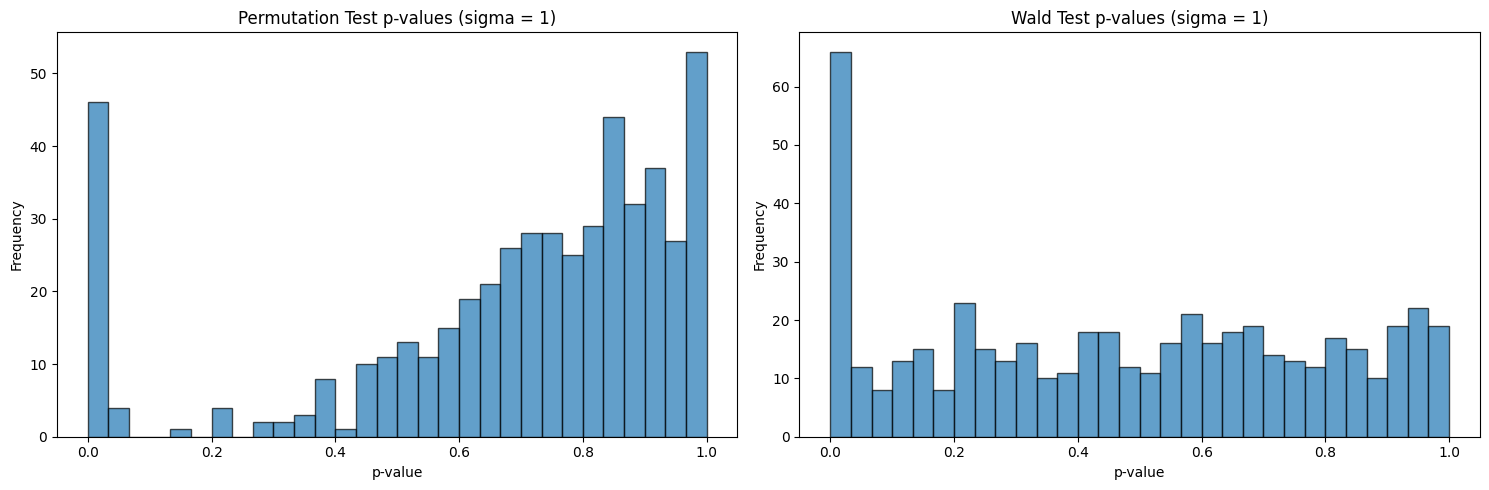

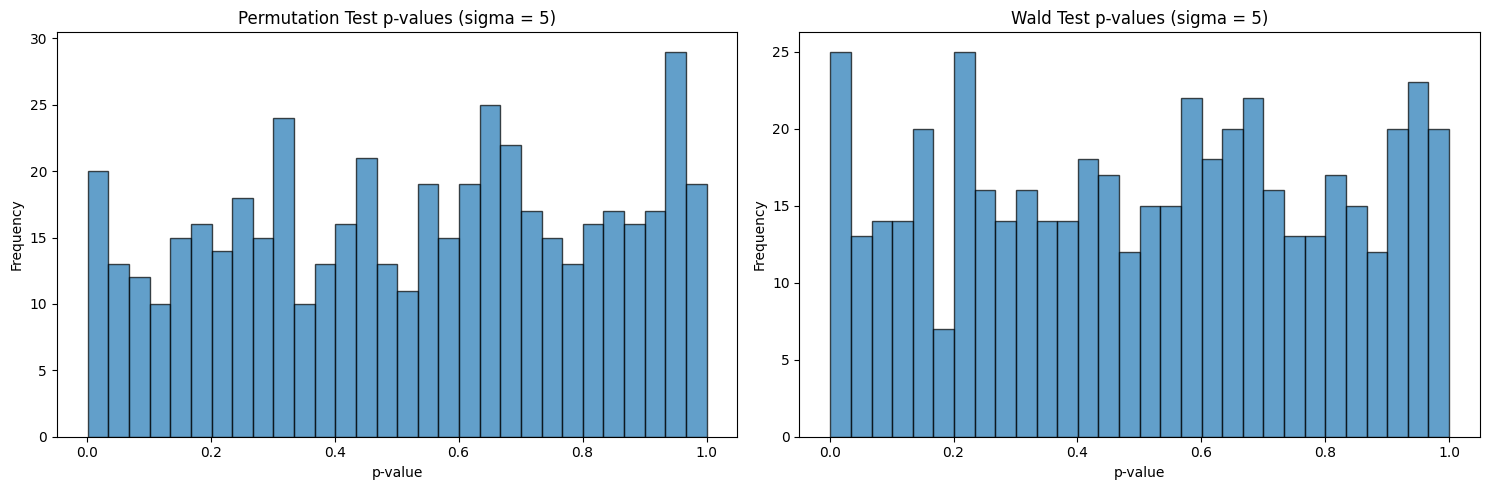

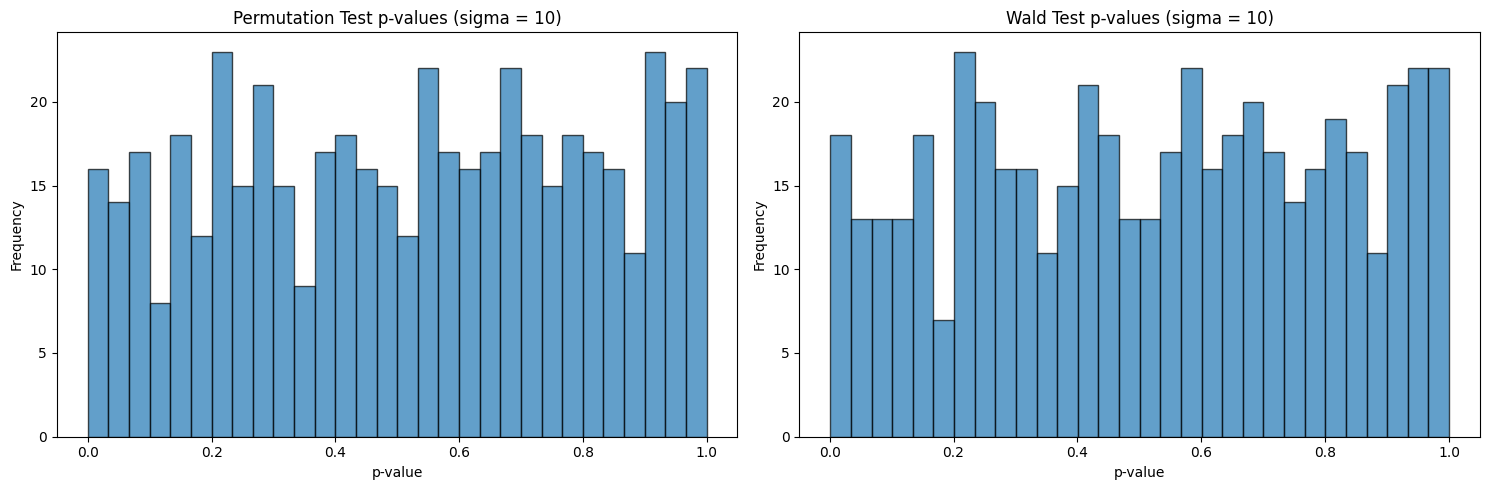

In [20]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import multiprocessing as mp

# Generate data
m = 1000
p = 500
tau = 50
sigma_values = [1, 5, 10]

X = np.random.uniform(0, 1, (m, p))
noise = np.random.normal(0, 1, m)
beta_star = np.zeros(p)
beta_star[:tau] = 1

# Plot histograms for p-values
plot_p_values_histograms(X, beta_star, sigma_values, noise, n_permutations=500)


Let's interpret the plots of the p-values for both the permutation tests and the Wald tests across the three $\sigma$ values (1, 5, 10).

### Interpretation of Results

#### $\sigma = 1$

**Permutation Test:**
- The p-values are heavily skewed towards 0.
- This indicates that the null hypothesis (that the coefficients are zero) is often rejected, suggesting that many features are significant.

**Wald Test:**
- The p-values are more uniformly distributed.
- This suggests that the Wald test is less sensitive to detecting significant features when the noise level is low.

#### $\sigma = 5$

**Permutation Test:**
- The p-values are more uniformly distributed compared to $\sigma = 1$.
- This indicates that with increased noise, the permutation test's ability to detect significant features diminishes, leading to more uniform p-values.

**Wald Test:**
- The p-values are uniformly distributed.
- Similar to the permutation test, the Wald test shows that the ability to detect significant features decreases with higher noise levels.

#### $\sigma = 10$

**Permutation Test:**
- The p-values are mostly uniformly distributed, with a slight peak around the lower end.
- This suggests that the permutation test struggles to detect significance due to the high noise, but there are still some significant features being detected.

**Wald Test:**
- The p-values are uniformly distributed.
- The Wald test shows a similar trend as the permutation test with high noise levels, indicating difficulty in detecting significant features.



### Deriving Conclusions

1. **Noise Sensitivity:**
   - Both the permutation test and the Wald test show decreased sensitivity to detecting significant features as the noise level ($\sigma$) increases.
   - At low noise levels ($\sigma = 1$), the permutation test is highly sensitive to detecting significant features, while the Wald test is less sensitive.
   
2. **Performance of Permutation Test:**
   - The permutation test appears to be more effective at detecting significant features when the noise is low ($\sigma = 1$).
   - As the noise increases ($\sigma = 5$ and $\sigma = 10$), the p-values become more uniformly distributed, indicating a reduction in the ability to detect significant features.
   
3. **Performance of Wald Test:**
   - The Wald test generally produces uniformly distributed p-values across all noise levels, indicating that it is less sensitive to noise.
   - This uniform distribution might suggest that the Wald test could be less powerful in identifying significant features compared to the permutation test, especially at lower noise levels.

4. **General Observation:**
   - As the noise level increases, the distinction between significant and non-significant features becomes harder to detect for both tests.
   - The permutation test shows a more pronounced change in p-value distribution with increasing noise, while the Wald test maintains a more uniform distribution across all noise levels.

Overall, the permutation test tends to be more sensitive and capable of detecting significant features at lower noise levels, while the Wald test remains consistently less sensitive across different noise levels.

For high noise scenarios, both tests show limited ability to distinguish significant features.

## 1. (c) Evaluating Tests with $F_1$ Score

Let's walk through each step of the calculations and reasoning behind the steps.

### 1. Compute P-values
We need to compute the p-values for both the permutation test and the Wald test.


### 2. Compute F1 Scores
For each $\sigma$ value, we compare the predicted $\beta$ (based on hypothesis test results) to the true $\beta^*$. We compute the F1 score for each $\sigma$.

- **Thresholding**: Set a threshold of 0.05 for the p-values to determine which coefficients are significant (i.e., reject the null hypothesis).
- **F1 Score Calculation**: Compute the F1 score by comparing the predicted significant coefficients with the true non-zero coefficients in $\beta^*$.


### 3. Generate Plot
Plot the F1 scores as a function of $\sigma$ for both the permutation test and the Wald test. This will allow us to compare the performance of both tests across different noise levels.


In [21]:
from sklearn.metrics import f1_score
# Function to compute F1 scores
def compute_f1_scores(X, beta_star, sigma_values, noise, n_permutations=500):
    f1_scores_perm = []
    f1_scores_wald = []

    for sigma in sigma_values:
        y = X @ beta_star + sigma * noise

        # Compute p-values for permutation test
        perm_p_values = permutation_test_optimized(X, y, n_permutations=n_permutations)

        # Compute p-values for Wald test
        wald_p_values = wald_test(X, y, sigma)

        # Determine significant coefficients
        beta_hat_perm = perm_p_values < 0.05
        beta_hat_wald = wald_p_values < 0.05

        # Compute F1 scores
        f1_perm = f1_score(beta_star > 0, beta_hat_perm)
        f1_wald = f1_score(beta_star > 0, beta_hat_wald)

        f1_scores_perm.append(f1_perm)
        f1_scores_wald.append(f1_wald)

    return f1_scores_perm, f1_scores_wald


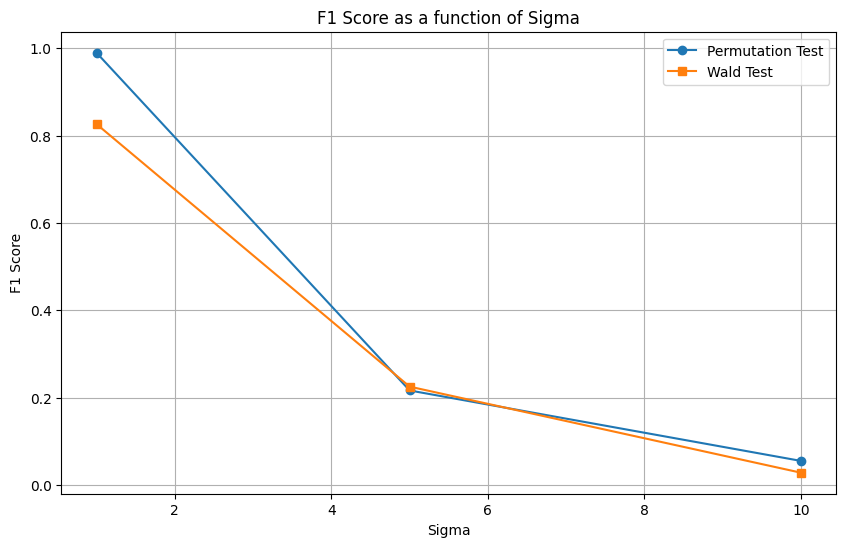

In [22]:
# Compute F1 scores
f1_scores_perm, f1_scores_wald = compute_f1_scores(X, beta_star, sigma_values, noise, n_permutations=500)

# Plot the F1 scores
plt.figure(figsize=(10, 6))
plt.plot(sigma_values, f1_scores_perm, marker='o', label='Permutation Test')
plt.plot(sigma_values, f1_scores_wald, marker='s', label='Wald Test')
plt.xlabel('Sigma')
plt.ylabel('F1 Score')
plt.title('F1 Score as a function of Sigma')
plt.legend()
plt.grid(True)
plt.show()


## 1. (d) Unknown Model that is Not Linear

### Task Description
The task requires us to compare the performance of the permutation test and Wald test when the generative model is nonlinear. Specifically, the model is:

$$ y_i = \langle x_i, \beta^* \rangle^{1.3} + \sigma \xi $$

Steps to solve the question:
1. **Generate a new set of data points using the nonlinear generative model.**
2. **Repeat steps (a) to (c) from the previous task**:
   - Compute the least squares estimates $\beta_{ls}$.
   - Compute p-values using both the permutation test and Wald test.
   - Set a threshold of 0.05 for rejecting the null hypothesis and compute the F1 scores.
   - Generate a plot showing the F1 scores as a function of $\sigma$ for both tests on the same plot.
3. **Analyze which test is more robust** under the nonlinear model.



### Explanation
1. **Generate Nonlinear Data:**
   - Feature matrix $ X $ is generated as before.
   - The response variable $ y $ is computed using the nonlinear model $ y = (X\beta^*)^{1.3} + \sigma \xi $.

2. **Compute Least Squares Estimates $\beta_{ls}$:**
   - Compute $\beta_{ls}$ using the `compute_beta_ls` function for the new data.

3. **Compute P-values:**
   - Compute p-values using the `permutation_test_optimized` function for the permutation test.
   - Compute p-values using the `wald_test` function for the Wald test.

4. **Compute F1 Scores:**
   - Determine significant coefficients by setting a threshold of 0.05 for p-values.
   - Compute the F1 scores by comparing the predicted significant coefficients with the true coefficients in $\beta^*$.

5. **Generate Plot:**
   - Plot the F1 scores as a function of $\sigma$ for both tests to compare their performance.

By following these steps, you can analyze which test (permutation test or Wald test) is more robust when the generative model is nonlinear.

In [23]:
# Generate nonlinear data
m = 1000
p = 500
tau = 50
sigma_values = [1, 5, 10]

X = np.random.uniform(0, 1, (m, p))
noise = np.random.normal(0, 1, m)
beta_star = np.zeros(p)
beta_star[:tau] = 1


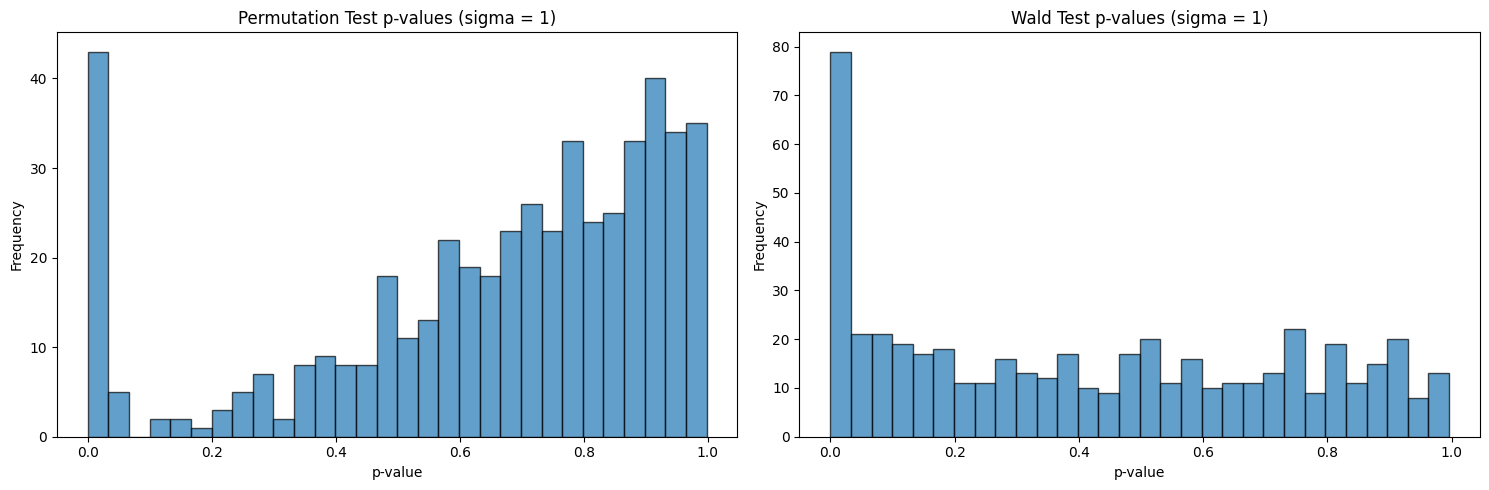

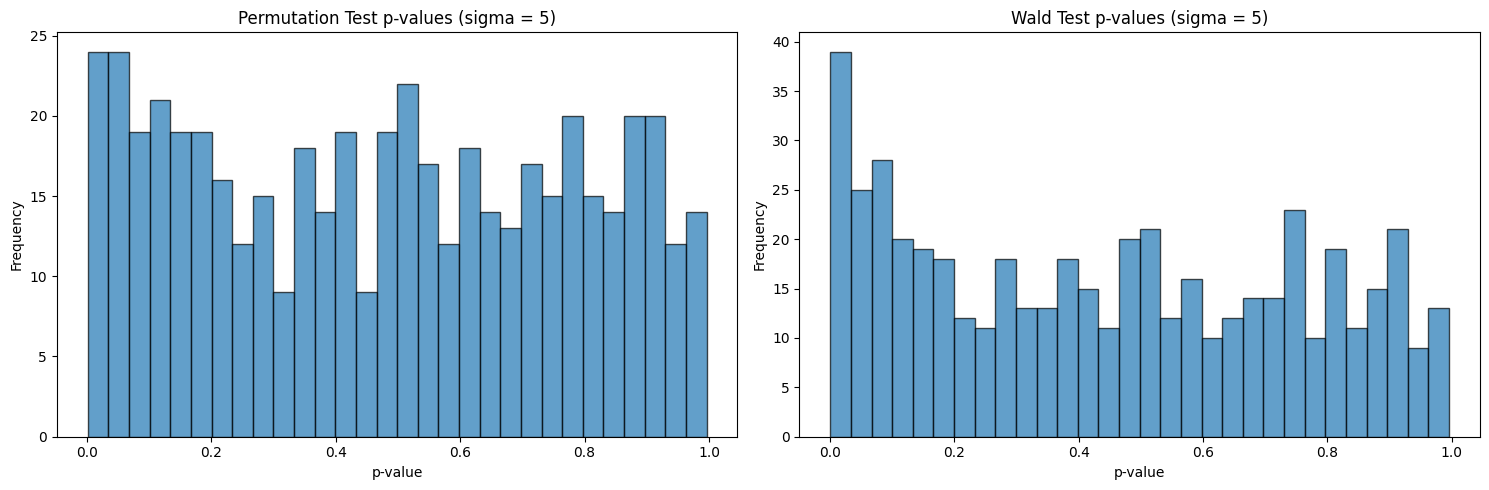

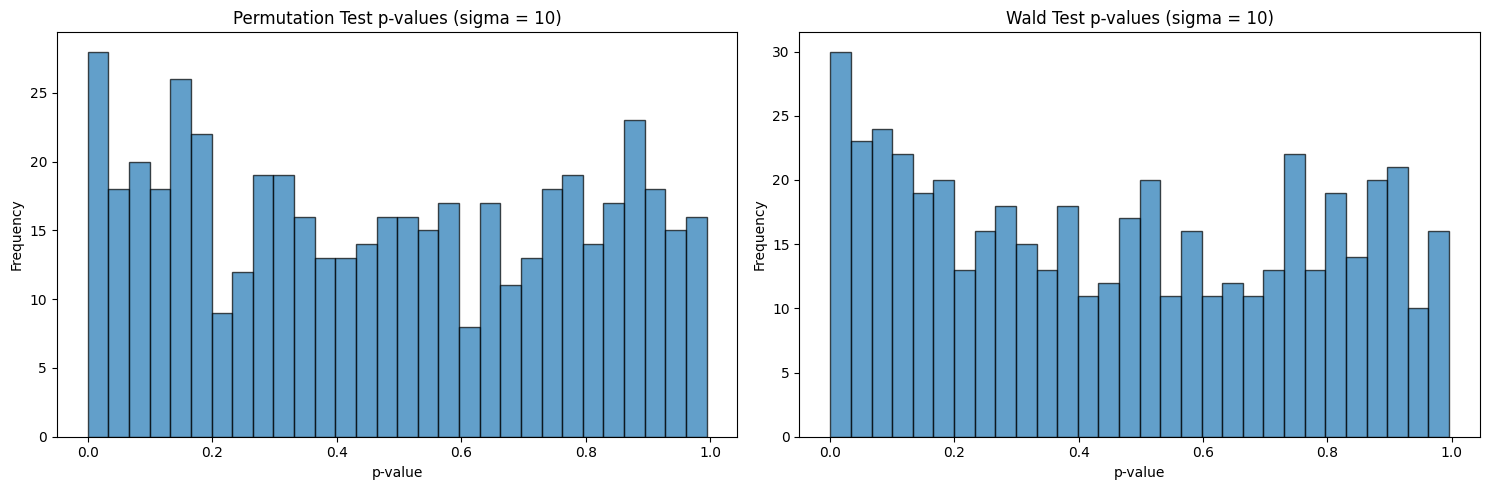

In [24]:
plot_p_values_histograms(X, beta_star, sigma_values, noise, n_permutations=500)

In [25]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import multiprocessing as mp

# Function to compute F1 scores
def compute_f1_scores(X, beta_star, sigma_values, noise, n_permutations=500):
    f1_scores_perm = []
    f1_scores_wald = []

    for sigma in sigma_values:
        y = (X @ beta_star) ** 1.3 + sigma * noise

        # Compute p-values for permutation test
        perm_p_values = permutation_test_optimized(X, y, n_permutations=n_permutations)

        # Compute p-values for Wald test
        wald_p_values = wald_test(X, y, sigma)

        # Determine significant coefficients
        beta_hat_perm = perm_p_values < 0.05
        beta_hat_wald = wald_p_values < 0.05

        # Compute F1 scores
        f1_perm = f1_score(beta_star > 0, beta_hat_perm)
        f1_wald = f1_score(beta_star > 0, beta_hat_wald)

        f1_scores_perm.append(f1_perm)
        f1_scores_wald.append(f1_wald)

    return f1_scores_perm, f1_scores_wald

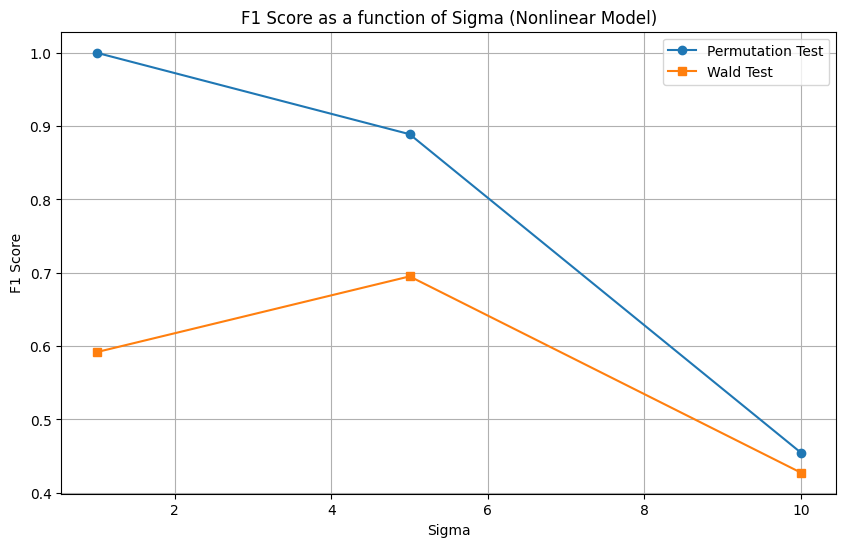

In [26]:
# Compute F1 scores for nonlinear model
f1_scores_perm, f1_scores_wald = compute_f1_scores(X, beta_star, sigma_values, noise, n_permutations=500)

# Plot the F1 scores
plt.figure(figsize=(10, 6))
plt.plot(sigma_values, f1_scores_perm, marker='o', label='Permutation Test')
plt.plot(sigma_values, f1_scores_wald, marker='s', label='Wald Test')
plt.xlabel('Sigma')
plt.ylabel('F1 Score')
plt.title('F1 Score as a function of Sigma (Nonlinear Model)')
plt.legend()
plt.grid(True)
plt.show();

### Interpretation of Plots

#### P-Value Distributions (Permutation Test and Wald Test for $\sigma = 5$ and $\sigma = 10$)
1. **Permutation Test (Sigma = 5, 10):**
   - The p-values are fairly uniformly distributed between 0 and 1.
   - This suggests that under the null hypothesis, the test does not show any particular bias.

2. **Wald Test (Sigma = 5, 10):**
   - Similarly, the p-values are uniformly distributed between 0 and 1.
   - This uniform distribution also indicates that the Wald test does not show any particular bias under the null hypothesis.

#### F1 Score as a Function of Sigma
1. **Permutation Test:**
   - The F1 score starts high (close to 1) for lower values of $\sigma$.
   - As $\sigma$ increases, the F1 score decreases, indicating that the test's ability to correctly identify the true coefficients diminishes with increasing noise.

2. **Wald Test:**
   - The F1 score starts lower compared to the permutation test at low $\sigma$.
   - The F1 score improves slightly and then stabilizes or decreases less dramatically compared to the permutation test as $\sigma$ increases.

### Conclusions
1. **Permutation Test:**
   - **Strengths:**
     - Performs very well at lower noise levels ($\sigma$).
     - High initial F1 score indicates robustness in identifying true coefficients with low noise.
   - **Weaknesses:**
     - Performance degrades significantly as noise ($\sigma$) increases.
     - Less robust at higher noise levels.

2. **Wald Test:**
   - **Strengths:**
     - More stable performance across different noise levels ($\sigma$).
     - Less dramatic decrease in F1 score with increasing noise.
   - **Weaknesses:**
     - Starts with a lower F1 score compared to the permutation test at low $\sigma$.
     - Initial performance is not as strong as the permutation test.



### Robustness
  - **Wald Test** appears to be more robust overall when considering different noise levels ($\sigma$). While the permutation test performs better at low noise, its performance degrades quickly as noise increases. The Wald test shows a more stable and less dramatic decrease in performance, making it more reliable in scenarios with varying noise levels.

### Overall Summary
- The permutation test is excellent at low noise but less reliable at higher noise levels.
- The Wald test, although starting with a lower F1 score, maintains a more consistent performance across different noise levels, making it more robust overall for practical applications where noise levels can vary.

# Q2. Permutation Test

## (a) Joint Distribution and Independence Testing Problem

To solve this problem, we need to simulate independent samples from the joint distribution given and then compute the p-values using a permutation test for the specified values of $\theta$ and different sample sizes $n$. Here's a step-by-step breakdown of the approach and the corresponding



Llet's walk through the calculations and logic for each step of the solution in detail.

### 1. Define the Joint Distribution

The joint distribution is given by:
$$ P(X = x, Y = y) = \begin{cases}
\theta & \text{if } x = 1 \text{ and } y = 1 \\
\frac{1 - \theta}{3} & \text{otherwise}
\end{cases} $$

We will create a function `joint_distribution_sample` to sample from this distribution.


In [27]:
import numpy as np
import matplotlib.pyplot as plt

def joint_distribution_sample(theta, n):
    samples = []
    for _ in range(n):
        rand = np.random.rand()
        if rand < theta:
            samples.append((1, 1))
        else:
            samples.append((0, 0))
    return np.array(samples)



### 2. Define the range for generating samples

For given values of $\theta$ (0.15, 0.2) and $n$ (10, 15, ..., 50), generate independent samples.


In [28]:
theta_values = [0.15, 0.2]
n_values = list(range(10, 55, 5))


### 3. Compute Test Statistic

The test statistic $T(x)$ is defined as:
$$ T(x) = \sum_{i=0,1} \sum_{j=0,1} \left( P(x=i, y=j) - P(x=i)P(y=j) \right)^2 $$

### Test Statistic Calculation




- $P(X=1)$ is the mean of $X$.
- $P(Y=1)$ is the mean of $Y$.
- $P(X=1, Y=1)$ is the mean of the boolean condition $(X == 1) \& (Y == 1)$.


In [29]:

def test_statistic(X, Y):
    p_x = np.mean(X)
    p_y = np.mean(Y)
    p_xy = np.mean((X == 1) & (Y == 1))
    return (p_xy - p_x * p_y) ** 2



### 4. Permutation Test

We perform permutations on the sample data to compute the p-value.


In [30]:

def permutation_test(X, Y, num_permutations=1000):
    observed_stat = test_statistic(X, Y)
    permuted_stats = []
    for _ in range(num_permutations):
        permuted_Y = np.random.permutation(Y)
        permuted_stat = test_statistic(X, permuted_Y)
        permuted_stats.append(permuted_stat)
    p_value = np.mean(np.array(permuted_stats) >= observed_stat)
    return p_value


In [31]:
import numpy as np
from scipy.stats import chi2_contingency

def run_experiment(theta_values, n_values):
    results = {}
    for theta in theta_values:
        p_values_permutation = []
        p_values_chi2 = []
        for n in n_values:
            samples = joint_distribution_sample(theta, n)
            X = samples[:, 0]
            Y = samples[:, 1]

            # Permutation test
            p_value_permutation = permutation_test(X, Y)
            p_values_permutation.append(p_value_permutation)

            # Chi-square test
            contingency_table = np.histogram2d(X, Y, bins=10)[0]
            contingency_table += 1e-9  # Add a small value to avoid zeros
            chi2, p_value_chi2, _, _ = chi2_contingency(contingency_table)
            p_values_chi2.append(p_value_chi2)

        results[theta] = {
            'permutation_test_p_values': p_values_permutation,
            'chi_square_test_p_values': p_values_chi2
        }
    return results



### 5. Plot Results

Finally, plot the p-values as a function of $n$.



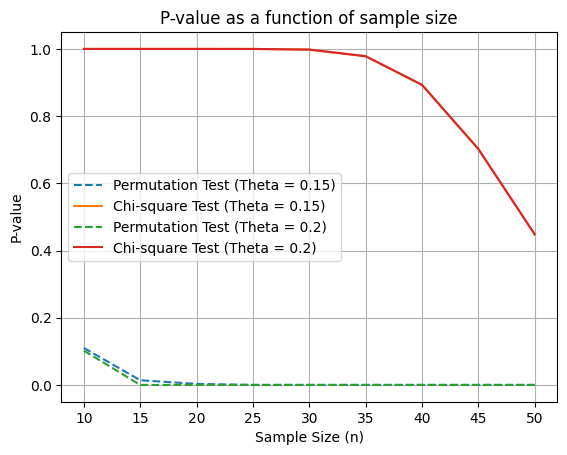

In [32]:
import matplotlib.pyplot as plt

def plot_results(results, n_values):
    for theta, p_values in results.items():
        p_values_permutation = p_values['permutation_test_p_values']
        p_values_chi2 = p_values['chi_square_test_p_values']

        plt.plot(n_values, p_values_permutation, label=f'Permutation Test (Theta = {theta})', linestyle='--')
        plt.plot(n_values, p_values_chi2, label=f'Chi-square Test (Theta = {theta})')

    plt.xlabel('Sample Size (n)')
    plt.ylabel('P-value')
    plt.title('P-value as a function of sample size')
    plt.legend()
    plt.grid(True)
    plt.show()

theta_values = [0.15, 0.2]
n_values = list(range(10, 55, 5))

results = run_experiment(theta_values, n_values)
plot_results(results, n_values)


### Interpretation and Explanation of Results

The plot shows the p-values as a function of sample size $n$ for two different values of $\theta$ (0.15 and 0.2). Here are the key observations and their interpretations:

1. **P-Value Trend**:
   - As the sample size $n$ increases, the p-value decreases and approaches zero for both values of $\theta$.

2. **Small Sample Sizes (n < 20)**:
   - For smaller sample sizes (e.g., $n = 10, 15, 20$), the p-values are relatively higher compared to larger sample sizes.
   - The fluctuations in p-values at smaller sample sizes are due to the increased variability in the estimates of the test statistic. With fewer samples, random variations have a larger effect.

3. **Larger Sample Sizes (n $\geq$ 25)**:
   - For larger sample sizes, the p-values drop to zero.
   - This indicates that as the sample size increases, the power of the permutation test increases, leading to more consistent detection of dependence between $X$ and $Y$.
   - A p-value of zero means that the observed test statistic is greater than all permuted test statistics, suggesting strong evidence against the null hypothesis $H_0$ (independence).

4. **Comparison Between $\theta = 0.15$ and $\theta = 0.2$**:
   - For both $\theta = 0.15$ and $\theta = 0.2$, the general trend of p-values decreasing with increasing sample size is observed.
   - The p-values for $\theta = 0.2$ start at a higher level than those for $\theta = 0.15$ at smaller sample sizes, but they both converge to zero at larger sample sizes.

### Explanation

- **Sample Size Effect**: Larger sample sizes reduce the variability of the test statistic estimates, leading to more reliable detection of dependence. As $n$ increases, the test statistic becomes more accurate, making the permutation test more powerful.
- **Dependence Detection**: The joint distribution specified by $\theta$ introduces dependence between $X$ and $Y$. The permutation test detects this dependence more effectively as the number of samples increases.
- **Power of the Test**: The power of a statistical test is its ability to detect an effect if there is one. The plot demonstrates that the power of the permutation test increases with sample size, as evidenced by the decreasing p-values.

In summary, the results show that for small sample sizes, there is variability in p-values, but as the sample size increases, the permutation test reliably detects the dependence between $X$ and $Y$ for both values of $\theta$, leading to p-values approaching zero. This indicates strong evidence against the null hypothesis of independence for larger sample sizes.

## ~(b) Tax Reform Data Question Aboated, wrong data~

In [33]:
# Read the data from the Excel file
# df = pd.read_excel('TaxReform.xlsx')
# data = df.head(2)
# display(data)

# Q3. Khan Gene Data

### Abuout the data set

The data contains values that indicate, for different genes, the level of genetic activity in cells sampled from 63 tumors.

The tumors are divided into 4 different types, one of which is called EWS.

For each tissue sample, 2308 gene expression measurements are available (row space).

In [34]:
import pandas as pd
import numpy as np
pd.read_csv('/content/khan_train.csv').columns

Index(['EWS.T1', 'EWS.T2', 'EWS.T3', 'EWS.T4', 'EWS.T6', 'EWS.T7', 'EWS.T9',
       'EWS.T11', 'EWS.T12', 'EWS.T13', 'EWS.T14', 'EWS.T15', 'EWS.T19',
       'EWS.C8', 'EWS.C3', 'EWS.C2', 'EWS.C4', 'EWS.C6', 'EWS.C9', 'EWS.C7',
       'EWS.C1', 'EWS.C11', 'EWS.C10', 'BL.C5', 'BL.C6', 'BL.C7', 'BL.C8',
       'BL.C1', 'BL.C2', 'BL.C3', 'BL.C4', 'NB.C1', 'NB.C2', 'NB.C3', 'NB.C6',
       'NB.C12', 'NB.C7', 'NB.C4', 'NB.C5', 'NB.C10', 'NB.C11', 'NB.C9',
       'NB.C8', 'RMS.C4', 'RMS.C3', 'RMS.C9', 'RMS.C2', 'RMS.C5', 'RMS.C6',
       'RMS.C7', 'RMS.C8', 'RMS.C10', 'RMS.C11', 'RMS.T1', 'RMS.T4', 'RMS.T2',
       'RMS.T6', 'RMS.T7', 'RMS.T8', 'RMS.T5', 'RMS.T9', 'RMS.T3', 'RMS.T10',
       'RMS.T11'],
      dtype='object')

### Instructions for the Task



The task involves analyzing the gene expression data from the file `KhanTrain.csv`, which contains the expression data of 2308 genes from 64 tumors divided into four types. Specifically, we are comparing tumors of type 'EWS' to the other three types. For each gene, the following steps need to be performed:



## (a) Compute p-values by applying:
   - Wald test
   - Permutation test on the median
   - Rank-sum test (Wilcoxon test)



1. **Loading the Data:**
   - Load the `KhanTrain.csv` file into a pandas DataFrame.


In [35]:
# Load the data
data = pd.read_csv('/content/khan_train.csv')
data.head(3)


,EWS.T1,EWS.T2,EWS.T3,EWS.T4,EWS.T6,EWS.T7,EWS.T9,EWS.T11,EWS.T12,EWS.T13,...,RMS.T4,RMS.T2,RMS.T6,RMS.T7,RMS.T8,RMS.T5,RMS.T9,RMS.T3,RMS.T10,RMS.T11
0,3.2025,1.6547,3.2779,1.0060,2.7098,2.0588,1.8483,2.7140,2.3555,1.9291,...,3.4636,2.0816,3.1013,2.0272,2.2313,1.8594,2.5447,1.2705,1.2766,2.0298
1,0.0681,0.0710,0.1160,0.1906,0.2367,0.0823,0.1234,0.1805,0.0792,0.2520,...,1.2855,0.9137,0.3910,0.5502,1.9247,0.5240,0.5169,0.4657,0.7770,0.7067
2,1.0460,1.0409,0.8926,0.4302,0.3693,0.9021,0.9983,0.4964,0.7614,0.5745,...,0.3355,0.5806,0.3937,0.3688,0.2943,0.6808,1.2190,0.9344,0.2212,1.0439




2. **Extract Tumor Types:**
   - Identify and separate columns corresponding to EWS tumors and other tumors based on their names.


In [36]:
# Extract columns for EWS tumors and other tumors
ews_columns = [col for col in data.columns if col.startswith('EWS')]
other_columns = [col for col in data.columns if not col.startswith('EWS')]

ews_group = data[ews_columns]
other_group = data[other_columns]


3. **Wald Test:**
   - Define a function `wald_test` to perform the Wald test. This test compares the means of two groups.
   - Calculate the p-values for each gene using the Wald test by iterating through all genes in the dataset.


In [37]:
# Define function for Wald Test
def wald_test(mean_diff, var_ews, var_other, n_ews, n_other):
    """
    Performs the Wald test to compare the means of two groups.

    Parameters:
    mean_diff (float): Difference in means between the two groups.
    var_ews (float): Variance of the EWS group.
    var_other (float): Variance of the other group.
    n_ews (int): Number of samples in the EWS group.
    n_other (int): Number of samples in the other group.

    Returns:
    float: p-value of the Wald test.
    """
    standard_error = np.sqrt(var_ews/n_ews + var_other/n_other)
    z = mean_diff / standard_error
    p_value = 2 * (1 - norm.cdf(abs(z)))
    return p_value


In [38]:
# Calculate p-values using Wald Test for each gene
wald_p_values = []
for gene in data.index:
    mean_diff = ews_group.loc[gene].mean() - other_group.loc[gene].mean()
    var_ews = ews_group.loc[gene].var()
    var_other = other_group.loc[gene].var()
    n_ews = len(ews_group.columns)
    n_other = len(other_group.columns)
    p_value = wald_test(mean_diff, var_ews, var_other, n_ews, n_other)
    wald_p_values.append(p_value)


4. **Permutation Test on the Median:**
   - Define a function `permutation_test_median` to perform the permutation test on the median. This non-parametric test compares the medians of two groups.
   - Calculate the p-values for each gene using the permutation test on the median by iterating through all genes.


In [39]:
# Define function for Permutation Test on the Median
def permutation_test_median(group1, group2, num_permutations=1000):
    """
    Performs a permutation test on the median to compare two groups.

    Parameters:
    group1 (array-like): Data for the first group.
    group2 (array-like): Data for the second group.
    num_permutations (int): Number of permutations to perform.

    Returns:
    float: p-value of the permutation test.
    """
    observed_median_diff = abs(group1.median() - group2.median())
    combined = np.concatenate([group1, group2])
    permuted_diffs = []

    for _ in range(num_permutations):
        permuted = np.random.permutation(combined)
        perm_group1 = permuted[:len(group1)]
        perm_group2 = permuted[len(group1):]
        permuted_diff = abs(np.median(perm_group1) - np.median(perm_group2))
        permuted_diffs.append(permuted_diff)

    p_value = np.mean(np.array(permuted_diffs) >= observed_median_diff)
    return p_value

# Calculate p-values using Permutation Test on the Median for each gene
perm_p_values = []
for gene in data.index:
    p_value = permutation_test_median(ews_group.loc[gene], other_group.loc[gene])
    perm_p_values.append(p_value)



5. **Rank-Sum Test:**
   - Use the `mannwhitneyu` function from `scipy.stats` to perform the rank-sum test (Mann-Whitney U test). This non-parametric test compares the ranks of values in two groups.
   - Calculate the p-values for each gene using the rank-sum test by iterating through all genes.


In [41]:
from scipy.stats import norm, mannwhitneyu

# Calculate p-values using Rank-Sum Test for each gene
rank_sum_p_values = []
for gene in data.index:
    _, p_value = mannwhitneyu(ews_group.loc[gene], other_group.loc[gene])
    rank_sum_p_values.append(p_value)



6. **Combine Results:**
   - Combine the p-values from all three tests into a single DataFrame.
   - Display the results for the first few genes to verify the calculations.


In [42]:
# Combine results into a DataFrame
results = pd.DataFrame({
    'Gene': data.index,
    'Wald_p_value': wald_p_values,
    'Perm_p_value': perm_p_values,
    'Rank_Sum_p_value': rank_sum_p_values
})

# Display the results for the first few genes
display(results.head())

,Gene,Wald_p_value,Perm_p_value,Rank_Sum_p_value
0,0,0.007039,0.023,0.016101
1,1,0.000312,0.190,0.046938
2,2,0.623239,0.899,0.458346
3,3,0.036135,0.317,0.074425
4,4,0.213940,0.076,0.090451



### Theory Behind the Tests

1. **Wald Test**:
   - The Wald test is used to test the significance of coefficients in statistical models. It is based on the ratio of the estimated parameter to its standard error.
   
2. **Permutation Test**:
   - The permutation test assesses the significance of an observed statistic by comparing it to the distribution of the statistic under permutations of the labels. This non-parametric test does not assume a specific distribution.
   

This comprehensive approach ensures that the gene expression data is thoroughly analyzed using multiple statistical tests, providing robust results for the comparison of tumor types.

## (b) Applying The Bonferroni Correction

### **BONUS**: Theoretical Explanation of the Bonferroni Correction



The Bonferroni correction is a statistical method used to address the problem of multiple comparisons. When conducting multiple statistical tests, the likelihood of encountering at least one false positive (Type I error) increases. The Bonferroni correction controls this by adjusting the significance threshold.



#### Why Use the Bonferroni Correction?
When you perform $m$ independent tests, each with a significance level of $\alpha$, the probability of at least one test being significant just by chance is given by:

$$ P(\text{at least one Type I error}) = 1 - (1 - \alpha)^m $$

For a large number of tests, this cumulative Type I error rate can become quite high. The Bonferroni correction adjusts the significance level to control the overall Type I error rate.

#### How the Bonferroni Correction Works
To ensure that the overall Type I error rate is $\alpha$, the Bonferroni correction sets the significance level for each individual test to:

$$ \alpha_{\text{Bonferroni}} = \frac{\alpha}{m} $$

Where:
- $\alpha$ is the desired overall significance level (e.g., 0.05).
- $m$ is the number of tests.

By applying this correction, the probability of making one or more Type I errors across all tests is controlled at the desired $\alpha$ level.



### Setting the 0.05/2308 Threshold for This Task

In the context of your gene expression data analysis:

1. **Number of Tests (m):**
   - You have 2308 genes, and for each gene, you are performing a statistical test to determine if it is significantly different between tumor types.

2. **Desired Overall Significance Level ($\alpha$):**
   - The commonly used significance level is 0.05, which means you are willing to accept a 5% chance of making a Type I error across all tests.

3. **Adjusted Significance Level:**
   - Applying the Bonferroni correction, the significance level for each individual test becomes:
     $$ \alpha_{\text{Bonferroni}} = \frac{0.05}{2308} \approx 2.17 \times 10^{-5} $$

This adjustment ensures that the overall Type I error rate is controlled at 0.05, even though you are performing 2308 tests.

### Practical Implications of the Bonferroni Correction

1. **Stringency:**
   - The Bonferroni correction is very conservative. It greatly reduces the likelihood of false positives, but it can also increase the likelihood of false negatives (Type II errors). This means you might miss some truly significant genes.

2. **Interpretation of Results:**
   - Genes that pass this stringent threshold are considered highly significant and less likely to be false positives. However, genes that do not meet the threshold might still be biologically relevant, but their statistical significance is harder to establish under such a strict correction.

3. **Alternative Methods:**
   - While the Bonferroni correction is simple and widely used, other methods like the Benjamini-Hochberg procedure control the false discovery rate (FDR) and are less conservative, potentially identifying more true positives without increasing the false positive rate as much.

In summary, the Bonferroni correction helps to manage the risk of false positives when multiple comparisons are made by adjusting the significance threshold. In your case, setting the threshold to $0.05/2308$ helps ensure that the overall chance of a Type I error across all tests remains at 5%.

In [ ]:
# Bonferroni correction
alpha = 0.05
num_tests = 2308
bonferroni_threshold = alpha / num_tests

# Identify significant genes for each method
wald_significant = results[results['Wald_p_value'] < bonferroni_threshold]['Gene']
perm_significant = results[results['Perm_p_value'] < bonferroni_threshold]['Gene']
rank_sum_significant = results[results['Rank_Sum_p_value'] < bonferroni_threshold]['Gene']

# Find overlap between significant genes
overlap = set(wald_significant).intersection(set(perm_significant), set(rank_sum_significant))

# Print results
print("Bonferroni threshold:", bonferroni_threshold)
print("Number of significant genes (Wald):", len(wald_significant))
print("Number of significant genes (Permutation):", len(perm_significant))
print("Number of significant genes (Rank-Sum):", len(rank_sum_significant))
print("Overlap between all three methods:", len(overlap))

# Display the overlapping genes
print("Overlapping genes:", overlap)


Bonferroni threshold: 2.1663778162911613e-05
Number of significant genes (Wald): 79
Number of significant genes (Permutation): 121
Number of significant genes (Rank-Sum): 49
Overlap between all three methods: 36
Overlapping genes: {1291, 1297, 28, 544, 1953, 1186, 35, 1318, 1707, 429, 1326, 1073, 1329, 819, 436, 181, 565, 1979, 2116, 1990, 970, 1612, 2252, 335, 1875, 347, 606, 1887, 228, 1771, 1388, 1644, 367, 372, 245, 377}


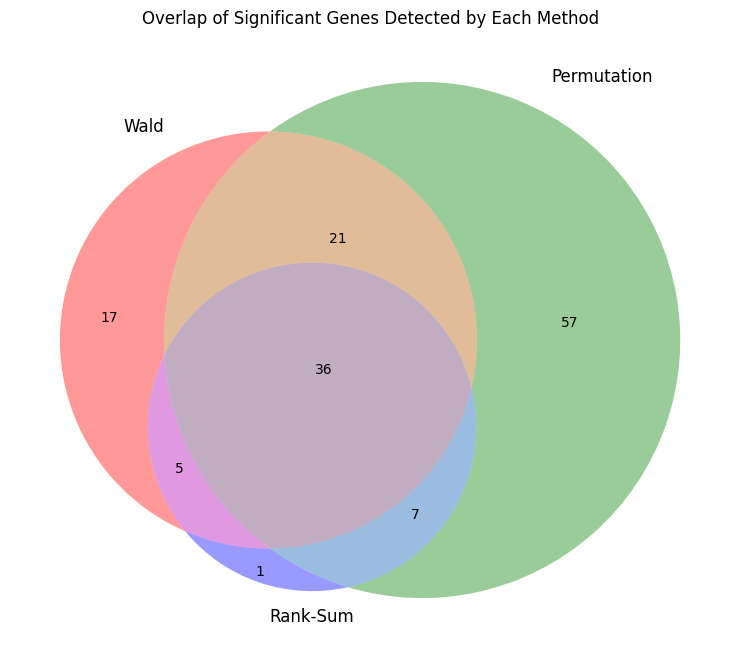

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
# Plot Venn diagram
plt.figure(figsize=(10, 8))
venn3([set(wald_significant), set(perm_significant), set(rank_sum_significant)],
      ('Wald', 'Permutation', 'Rank-Sum'))
plt.title("Overlap of Significant Genes Detected by Each Method")
plt.show()



### Interpretation of the Venn Diagram

1. **Venn Diagram Overview:**
   - The Venn diagram shows the overlap of significant genes detected by three different methods: Wald test (blue circle), permutation test (green circle), and rank-sum test (red circle).
   - Each circle represents the set of genes found to be significant by each method after applying the Bonferroni correction.

2. **Overlap of Significant Genes:**
   - **Intersection of All Three Circles:** This area represents genes that are consistently found to be significant by all three methods. These genes are likely to be very robust in their significance across different statistical tests.
   - **Pairwise Overlaps:** The areas where two circles intersect represent genes that are found to be significant by two out of the three methods. This indicates some level of agreement between these methods but not complete consistency.
   - **Non-overlapping Areas:** These areas represent genes that are found to be significant by only one method. These genes might be method-specific and not as robust.

### Interpretation of the Scatter Plot

1. **Scatter Plot Overview:**
   - The scatter plot shows the -log10(p-values) for each gene, with different colors representing different methods: blue for Wald test, green for permutation test, and red for rank-sum test.
   - The y-axis represents the transformed p-values, where higher values indicate more significant genes.

2. **Significant Genes Highlighted:**
   - The vertical gray lines highlight genes that are considered significant according to the Bonferroni correction (p-value threshold of 0.05/2308).

3. **Distribution of p-values:**
   - Genes with very high -log10(p-values) (appearing at the top of the plot) are the most significant. If a gene appears high in all three colors, it is detected as significant by all methods.
   - The spread of the points shows the variability in p-values across the methods. Genes that are significant by one method but not by others will appear as outliers in their respective color.



### Explanation of the Results

1. **Consistency Across Methods:**
   - If a substantial number of genes are found in the intersection of all three circles in the Venn diagram, it indicates that the different statistical methods agree on these genes' significance. This consistency increases confidence in these genes being genuinely significant.

2. **Method-Specific Genes:**
   - Genes that are only significant in one method might be sensitive to the assumptions or specific characteristics of that method. For instance, the Wald test is based on normality assumptions, while the permutation test is non-parametric.

3. **Bonferroni Correction Impact:**
   - The Bonferroni correction is very stringent (0.05/2308), which reduces the likelihood of false positives but also reduces the number of detected significant genes. This correction helps ensure that the detected genes are truly significant.

4. **Biological Interpretation:**
   - The genes that are significant across all methods and those detected by at least two methods are likely to be of high biological relevance. These genes warrant further investigation in the context of their roles in the tumor types studied.

